In [1]:
### TODO 

# consider removing genes that are not consistent across replicates
# compare results with DESEq2
# BLAST reads not mapped
# ST. Recover failed samples on consistent genes

In [2]:
import pandas, numpy, umap
import matplotlib, matplotlib.pyplot
import sklearn, sklearn.preprocessing, sklearn.decomposition
import scipy, scipy.stats
import statsmodels, statsmodels.api

matplotlib.rcParams.update({'font.size':18,'font.family':'Arial','xtick.labelsize':14,'ytick.labelsize':14})
matplotlib.rcParams['pdf.fonttype']=42

In [3]:
def histogrammer(theData):

    '''
    This function creates a histogram.
    '''    

    x=[]; y=[]
    
    binSize=0.1
    left=0
    right=5
    rightBins=numpy.arange(left+binSize,right+binSize,binSize)
    n,bins=numpy.histogram(theData,bins=rightBins)

    halfBin=(bins[1]-bins[0])/2.
    for bin in bins:
        center=bin+halfBin
        x.append(center)
    x.pop()
    y=numpy.array(n)
    y=list(y/float(sum(y)))

    return x,y

In [4]:
def regressionAnalysis(x,y):

    '''
    This function performs regression analysis based on:
    http://markthegraph.blogspot.com/2015/05/using-python-statsmodels-for-ols-linear.html
    '''
    
    # f.0 run a simple correlation analysis
    print('\t regression results:')
    slope,intercept,r_value,p_value,std_err=scipy.stats.linregress(x,y)
    print('\t\t slope',slope)
    print('\t\t intercept',intercept)
    print('\t\t r_value',r_value)
    print('\t\t pvalue',p_value)
    print('\t\t std_err',std_err)

    # f.1. build regression model
    xc=statsmodels.api.add_constant(x) # constant intercept term
    model=statsmodels.api.OLS(y,xc)
    fitted=model.fit()

    # f.2. interpolate model
    a=x.min()
    b=x.max()
    x_pred=numpy.linspace(a,b,250)
    x_pred2=statsmodels.api.add_constant(x_pred)
    y_pred=fitted.predict(x_pred2)
    regressionLine=[x_pred,y_pred]

    # f.3. compute CI
    y_hat=fitted.predict(xc)
    y_err=y-y_hat
    mean_x=xc.T[1].mean()
    n=len(xc)
    dof=n-fitted.df_model-1
    t=scipy.stats.t.ppf(1-0.025,df=dof)
    s_err=numpy.sum(numpy.power(y_err, 2))
    conf = t * numpy.sqrt((s_err/(n-2))*(1.0/n + (numpy.power((x_pred-mean_x),2) / ((numpy.sum(numpy.power(x_pred,2))) - n*(numpy.power(mean_x,2))))))
    upper=y_pred+abs(conf)
    lower=y_pred-abs(conf)
    CI=[upper,lower]

    # f.4. compute PI
    sdevP,lowerP,upperP=statsmodels.sandbox.regression.predstd.wls_prediction_std(fitted,exog=x_pred2,alpha=0.05)
    PI=[upperP,lowerP]

    return regressionLine,CI,PI

# 0. user-defined variables

In [5]:
expression_file = '/Volumes/omics4tb2/alomana/projects/cdi/results/expression.640/expression_matrix.txt'

# 1. read file

In [6]:
df = pandas.read_csv(expression_file,sep='\t',index_col=0)
df = df.T

print(df.shape)
df.head(n=25)

(24, 188753)


,ENST00000000233.10,ENST00000000412.8,ENST00000000442.11,ENST00000001008.6,ENST00000001146.6,ENST00000002125.9,ENST00000002165.10,ENST00000002501.10,ENST00000002596.6,ENST00000002829.8,...,ENST00000652760.1,ENST00000652762.1,ENST00000652763.1,ENST00000652764.1,ENST00000652765.1,ENST00000652766.1,ENST00000652767.1,ENST00000652768.1,ENST00000652770.1,ENST00000652771.1
01_MM1S_0hr_R1,323.2670,23.25410,23.35050,62.6772,0.0,0.255066,2.687910,0.937309,0.413828,0.000000e+00,...,0.000000,0.303747,0.000000,0.069403,0.0,0.000000,0.083418,0.0,1.314030,0.000000
02_MM1S_0hr_R2,286.9660,20.76130,19.36910,56.3636,0.0,0.721131,2.011270,0.732951,0.272340,0.000000e+00,...,0.013928,0.136677,0.000000,0.000000,0.0,0.000000,0.248895,0.0,1.030990,0.000000
03_MM1S_0hr_R3,184.8040,1.65553,3.87648,47.1638,0.0,0.185414,0.972517,0.552429,0.124123,0.000000e+00,...,0.000000,0.470219,0.000000,0.044430,0.0,0.000000,0.046789,0.0,1.300720,0.000000
04_MM1S_1hr_R1,287.9250,30.92790,19.03710,62.5564,0.0,1.275010,2.746690,0.661802,0.403686,2.166430e-02,...,0.000000,0.224264,0.077113,0.087275,0.0,0.000000,0.139932,0.0,1.033970,0.447028
05_MM1S_1hr_R2,410.7170,31.33520,24.12760,56.4552,0.0,0.000000,3.068600,1.044900,0.366868,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000
06_MM1S_1hr_R3,278.4350,24.30500,22.18680,52.5117,0.0,0.691382,2.333340,0.788618,0.393235,0.000000e+00,...,0.000000,0.190238,0.000000,0.084856,0.0,0.000000,0.082078,0.0,0.560893,0.502480
07_MM1S_4hr_R1,254.8460,25.52280,17.66990,62.2645,0.0,0.625084,2.988090,0.411494,0.234560,0.000000e+00,...,0.000000,0.305719,0.000000,0.000000,0.0,0.000000,0.067624,0.0,0.320139,0.234955
08_MM1S_4hr_R2,275.2180,30.11050,17.47850,67.2731,0.0,1.136710,3.425240,0.852753,0.264430,0.000000e+00,...,0.000000,0.605128,0.000000,0.053956,0.0,0.000000,0.164884,0.0,1.221810,0.240947
09_MM1S_4hr_R3,287.4320,31.25840,17.78220,78.6354,0.0,0.624498,4.465800,0.354639,0.294622,0.000000e+00,...,0.000000,0.528731,0.047872,0.090906,0.0,0.000000,0.000000,0.0,0.609888,0.000000
10_MM1S_24hr_R1,0.0000,0.00000,0.00000,166.1020,0.0,0.000000,0.000000,0.000000,0.000000,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000


# 2. data exploration 

## 2.1. expression distributions

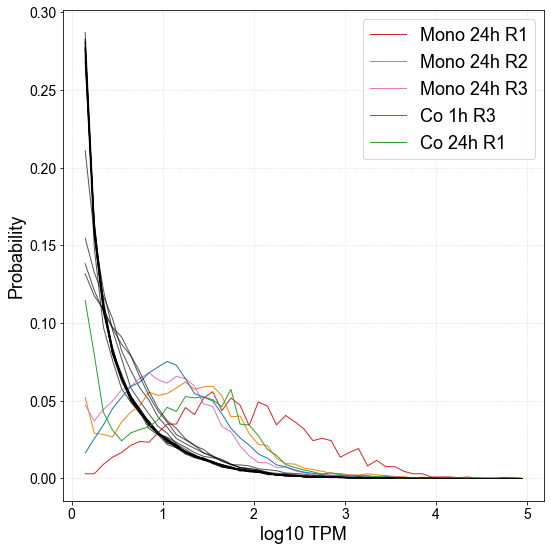

In [7]:
matplotlib.pyplot.figure(None, (8,8))
for element in df.index:
    the_data = numpy.log10(numpy.array(df.loc[element])+1)
    x, y = histogrammer(the_data)
    
    if '10' in element:
        matplotlib.pyplot.plot(x,y,'-',color='tab:red',lw=1,label='Mono 24h R1')
    elif '18' in element:
        matplotlib.pyplot.plot(x, y, '-',color='tab:blue',lw=1,label='Co 1h R3')
    elif '22' in element:
        matplotlib.pyplot.plot(x, y, '-',color='tab:green',lw=1,label='Co 24h R1')
    elif '11' in element:
        matplotlib.pyplot.plot(x, y, '-',color='tab:orange',lw=1,label='Mono 24h R2')
    elif '12' in element:
        matplotlib.pyplot.plot(x, y, '-',color='tab:pink',lw=1,label='Mono 24h R3')
    else:
        matplotlib.pyplot.plot(x,y,'-',color='black',lw=1, alpha=2/3)

matplotlib.pyplot.legend()
matplotlib.pyplot.grid(True,alpha=0.5,ls=':')
matplotlib.pyplot.xlabel('log10 TPM')
matplotlib.pyplot.ylabel('Probability')
matplotlib.pyplot.tight_layout()

In [8]:
gq_samples = df.drop(['10_MM1S_24hr_R1', '11_MM1S_24hr_R2', '12_MM1S_24hr_R3', '18_hFOB-MM1S_1hr_R3', '22_hFOB-MM1S_24hr_R1'])
gq_samples

,ENST00000000233.10,ENST00000000412.8,ENST00000000442.11,ENST00000001008.6,ENST00000001146.6,ENST00000002125.9,ENST00000002165.10,ENST00000002501.10,ENST00000002596.6,ENST00000002829.8,...,ENST00000652760.1,ENST00000652762.1,ENST00000652763.1,ENST00000652764.1,ENST00000652765.1,ENST00000652766.1,ENST00000652767.1,ENST00000652768.1,ENST00000652770.1,ENST00000652771.1
01_MM1S_0hr_R1,323.267,23.25410,23.35050,62.6772,0.0,0.255066,2.687910,0.937309,0.413828,0.000000e+00,...,0.000000,0.303747,0.000000,0.069403,0.0,0.000000,0.083418,0.0,1.314030,0.000000
02_MM1S_0hr_R2,286.966,20.76130,19.36910,56.3636,0.0,0.721131,2.011270,0.732951,0.272340,0.000000e+00,...,0.013928,0.136677,0.000000,0.000000,0.0,0.000000,0.248895,0.0,1.030990,0.000000
03_MM1S_0hr_R3,184.804,1.65553,3.87648,47.1638,0.0,0.185414,0.972517,0.552429,0.124123,0.000000e+00,...,0.000000,0.470219,0.000000,0.044430,0.0,0.000000,0.046789,0.0,1.300720,0.000000
04_MM1S_1hr_R1,287.925,30.92790,19.03710,62.5564,0.0,1.275010,2.746690,0.661802,0.403686,2.166430e-02,...,0.000000,0.224264,0.077113,0.087275,0.0,0.000000,0.139932,0.0,1.033970,0.447028
05_MM1S_1hr_R2,410.717,31.33520,24.12760,56.4552,0.0,0.000000,3.068600,1.044900,0.366868,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000
06_MM1S_1hr_R3,278.435,24.30500,22.18680,52.5117,0.0,0.691382,2.333340,0.788618,0.393235,0.000000e+00,...,0.000000,0.190238,0.000000,0.084856,0.0,0.000000,0.082078,0.0,0.560893,0.502480
07_MM1S_4hr_R1,254.846,25.52280,17.66990,62.2645,0.0,0.625084,2.988090,0.411494,0.234560,0.000000e+00,...,0.000000,0.305719,0.000000,0.000000,0.0,0.000000,0.067624,0.0,0.320139,0.234955
08_MM1S_4hr_R2,275.218,30.11050,17.47850,67.2731,0.0,1.136710,3.425240,0.852753,0.264430,0.000000e+00,...,0.000000,0.605128,0.000000,0.053956,0.0,0.000000,0.164884,0.0,1.221810,0.240947
09_MM1S_4hr_R3,287.432,31.25840,17.78220,78.6354,0.0,0.624498,4.465800,0.354639,0.294622,0.000000e+00,...,0.000000,0.528731,0.047872,0.090906,0.0,0.000000,0.000000,0.0,0.609888,0.000000
13_hFOB-MM1S_0hr_R1,230.546,16.71890,27.85710,84.4751,0.0,0.846682,2.561310,1.183130,0.110355,3.903480e-01,...,0.000000,0.595796,0.039708,0.000000,0.0,0.000000,0.000000,0.0,0.300809,0.000000


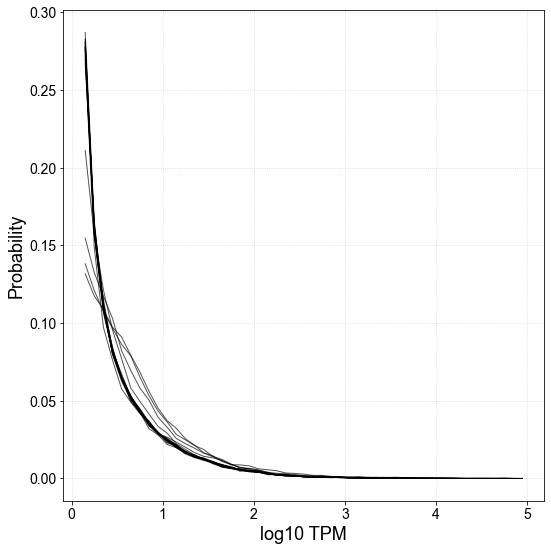

In [9]:
matplotlib.pyplot.figure(None, (8,8))
for element in gq_samples.index:
    the_data = numpy.log10(numpy.array(gq_samples.loc[element])+1)
    x, y = histogrammer(the_data)
    matplotlib.pyplot.plot(x,y,'-',color='black',lw=1, alpha=2/3)

matplotlib.pyplot.grid(True,alpha=0.5,ls=':')
matplotlib.pyplot.xlabel('log10 TPM')
matplotlib.pyplot.ylabel('Probability')
matplotlib.pyplot.tight_layout()

## 2.1. define highly variable transcripts

In [10]:
mean_values = gq_samples.mean(axis = 0)
std_values = gq_samples.std(axis = 0)
gq_samples.loc['mean'] = mean_values
gq_samples.loc['std'] = std_values
gq_samples.tail()

,ENST00000000233.10,ENST00000000412.8,ENST00000000442.11,ENST00000001008.6,ENST00000001146.6,ENST00000002125.9,ENST00000002165.10,ENST00000002501.10,ENST00000002596.6,ENST00000002829.8,...,ENST00000652760.1,ENST00000652762.1,ENST00000652763.1,ENST00000652764.1,ENST00000652765.1,ENST00000652766.1,ENST00000652767.1,ENST00000652768.1,ENST00000652770.1,ENST00000652771.1
21_hFOB-MM1S_4hr_R3,201.288000,31.948700,22.965800,100.489000,0.0,1.010330,3.240870,0.598355,0.132303,0.000000,...,0.000000,0.252132,0.000000,0.020981,0.0,0.000000,0.086414,0.0,0.590309,0.000000
23_hFOB-MM1S_24hr_R2,156.033000,5.913880,0.000000,37.100000,0.0,0.000000,6.185350,0.458578,0.198265,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,3.767760,0.000000
24_hFOB-MM1S_24hr_R3,111.148000,19.932000,9.221540,68.804300,0.0,1.657770,19.480200,7.768330,0.248662,3.048300,...,0.000000,0.938507,0.000000,0.034128,0.0,0.000000,4.514750,0.0,4.489880,0.000000
mean,239.557368,23.445564,19.578312,72.093816,0.0,0.828545,4.102178,1.093154,0.220898,0.237674,...,0.000733,0.316859,0.010571,0.052042,0.0,0.006526,0.321184,0.0,1.126263,0.241445
std,67.921146,8.321569,7.811648,18.230040,0.0,0.560922,3.878764,1.631557,0.113215,0.700774,...,0.003195,0.236038,0.022359,0.049755,0.0,0.028446,1.019717,0.0,1.164079,0.463796


In [11]:
# remove transcripts below average 10 TPMs
subset = gq_samples.loc[:, gq_samples.loc['mean'] >= 10]

subset.loc['cv'] = gq_samples.loc['std'] / gq_samples.loc['mean']
print(subset.shape)
subset.tail()

(22, 5784)


/Users/alomana/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,ENST00000000233.10,ENST00000000412.8,ENST00000000442.11,ENST00000001008.6,ENST00000005340.10,ENST00000006275.8,ENST00000006750.7,ENST00000006777.11,ENST00000007264.7,ENST00000007390.3,...,ENST00000652231.1,ENST00000652272.1,ENST00000652277.1,ENST00000652288.1,ENST00000652332.1,ENST00000652429.1,ENST00000652455.1,ENST00000652489.1,ENST00000652521.1,ENST00000652617.1
23_hFOB-MM1S_24hr_R2,156.033000,5.913880,0.000000,37.100000,3.947090,4.851830,0.000000,3.098270,13.548700,93.238400,...,1.320610,0.000000,0.000000,5.996170,24.468800,2.096070,2.096070,34.311800,0.397583,2.253730
24_hFOB-MM1S_24hr_R3,111.148000,19.932000,9.221540,68.804300,6.739540,2.936360,4.926950,17.726600,39.332300,76.385600,...,15.097300,7.434960,0.000000,15.721000,82.448400,1.159960,1.159960,22.355200,12.472400,14.085500
mean,239.557368,23.445564,19.578312,72.093816,16.761081,11.961593,22.490834,23.669401,39.624616,108.983421,...,15.045133,18.365778,10.665446,88.013621,106.731532,22.052099,22.052099,35.969163,17.560238,21.793253
std,67.921146,8.321569,7.811648,18.230040,6.518974,7.441873,18.890845,8.947894,18.622193,32.806642,...,5.098849,7.478162,5.236019,47.306427,36.042914,10.356915,10.356915,27.003864,5.797380,9.600758
cv,0.283528,0.354931,0.398995,0.252866,0.388935,0.622147,0.839935,0.378036,0.469965,0.301024,...,0.338904,0.407179,0.490933,0.537490,0.337697,0.469657,0.469657,0.750750,0.330142,0.440538


In [12]:
# compute regression model
x = numpy.array(numpy.log10(subset.loc['mean']))
y = numpy.array(numpy.log10(subset.loc['std']))
regressionLine, CI, PI = regressionAnalysis(x, y)

	 regression results:
		 slope 0.9080154380596858
		 intercept -0.21016312546739968
		 r_value 0.8923639125984826
		 pvalue 0.0
		 std_err 0.006039395483290095


/Users/alomana/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in sqrt


In [13]:
# identify highly variable transcripts
HVTs=[]; HVT_positions_x=[]; HVT_positions_y=[]
VTs=[]; VT_positions_x=[]; VT_positions_y=[]
for i in range(len(x)):
    transcript_name = subset.columns[i]
    observed = y[i]
    closer_index = numpy.argmin([numpy.abs(x[i]-probe) for probe in regressionLine[0]])
    expected = PI[0][closer_index]
    average = regressionLine[1][closer_index]
    
    if observed > expected:
        HVTs.append(transcript_name)
        HVT_positions_x.append(x[i]); HVT_positions_y.append(y[i])
        
    if observed > average:
        VTs.append(transcript_name)
        VT_positions_x.append(x[i]); VT_positions_y.append(y[i])

print(len(HVTs))
print(len(VTs))

301
2339


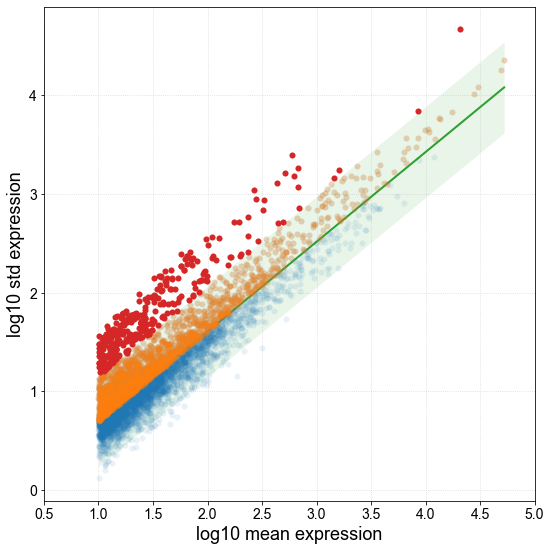

In [14]:
# plot
matplotlib.pyplot.figure(None, (8,8))

matplotlib.pyplot.plot(regressionLine[0], regressionLine[1], color='tab:green', lw=2)
matplotlib.pyplot.fill_between(regressionLine[0], PI[1], PI[0], color='tab:green', alpha=0.1, lw=0)
matplotlib.pyplot.plot(x, y, 'o', alpha=0.1, mew=0)
matplotlib.pyplot.plot(VT_positions_x, VT_positions_y, 'o', alpha=0.25, mew=0, color='tab:orange')
matplotlib.pyplot.plot(HVT_positions_x, HVT_positions_y, 'o', alpha=1, mew=0, color='tab:red')

matplotlib.pyplot.xlabel('log10 mean expression')
matplotlib.pyplot.ylabel('log10 std expression')
matplotlib.pyplot.xlim([0.5, 5])
matplotlib.pyplot.grid(True,alpha=0.5,ls=':')
matplotlib.pyplot.tight_layout()

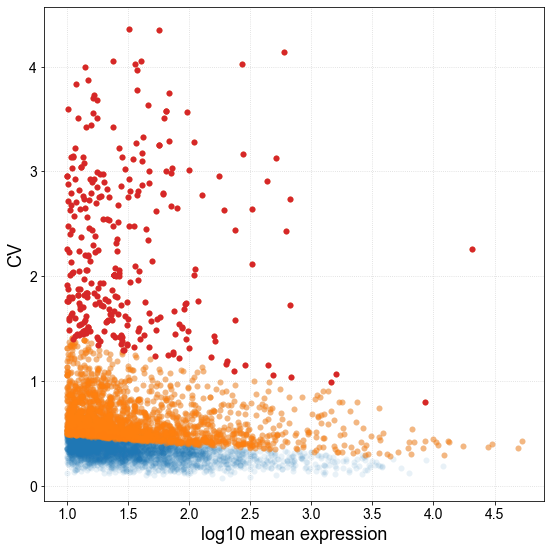

In [15]:
matplotlib.pyplot.figure(None, (8,8))
matplotlib.pyplot.plot(numpy.log10(subset.loc['mean']), subset.loc['cv'], 'o', alpha=0.1, mew=0)
matplotlib.pyplot.plot(numpy.log10(subset.loc['mean', VTs]), subset.loc['cv', VTs], 'o', alpha=0.5, mew=0, color='tab:orange')
matplotlib.pyplot.plot(numpy.log10(subset.loc['mean', HVTs]), subset.loc['cv', HVTs], 'o', alpha=1, mew=0, color='tab:red')

matplotlib.pyplot.xlabel('log10 mean expression')
matplotlib.pyplot.ylabel('CV')
matplotlib.pyplot.grid(True,alpha=0.5,ls=':')
matplotlib.pyplot.tight_layout()

In [16]:
HV_df = gq_samples.loc[:, HVTs]
HV_df.drop(['mean', 'std'], inplace=True)

print(HV_df.shape)
HV_df.tail()

(19, 301)


,ENST00000084795.9,ENST00000215909.10,ENST00000216117.9,ENST00000216281.12,ENST00000216341.9,ENST00000218388.9,ENST00000223095.4,ENST00000224237.9,ENST00000225964.9,ENST00000227378.7,...,ENST00000626854.2,ENST00000631728.1,ENST00000633006.1,ENST00000633158.1,ENST00000633481.1,ENST00000637937.1,ENST00000638691.1,ENST00000641191.1,ENST00000642867.1,ENST00000649529.1
19_hFOB-MM1S_4hr_R1,2.56120,787.386,64.4860,29.5459,0.744195,53.2548,24.23760,56.1582,22.7712,8.27888,...,6.57303,0.000003,7.85655,6.32128,4.83740,44.8899,3.41075,2.07899,3.335690e+01,557.419
20_hFOB-MM1S_4hr_R2,44.58400,795.332,59.1480,53.0470,0.453998,37.5696,9.51791,40.0065,8.9607,68.91950,...,7.07194,219.639000,10.18600,4.33513,8.55457,73.8567,4.24142,13.58270,8.766530e-09,713.651
21_hFOB-MM1S_4hr_R3,1.92550,582.797,63.2955,39.4492,0.780875,26.6612,4.84771,33.0731,2.8963,54.40340,...,5.82928,0.000173,8.13216,15.76410,5.88330,47.5834,3.18991,3.57206,2.188980e+01,479.642
23_hFOB-MM1S_24hr_R2,1140.31000,4929.700,360.6230,813.0100,160.132000,218.5150,71.60660,298.7000,31.7351,246.72400,...,1.07380,1550.580000,74.79370,8.12721,101.81800,260.7070,33.52310,46.69260,3.773820e+01,4728.720
24_hFOB-MM1S_24hr_R3,5.10438,5223.540,525.7820,729.9570,209.697000,412.8120,390.10000,998.5710,245.8210,535.29400,...,3.40084,2647.250000,80.07440,0.00000,47.34170,163.3760,0.00000,165.11500,3.949990e-02,2682.000


In [17]:
V_df = gq_samples.loc[:, VTs]
V_df.drop(['mean', 'std'], inplace=True)

print(V_df.shape)
V_df.tail()

(19, 2339)


,ENST00000006275.8,ENST00000006750.7,ENST00000007264.7,ENST00000009180.10,ENST00000022615.9,ENST00000035307.6,ENST00000037243.7,ENST00000084795.9,ENST00000155840.10,ENST00000157812.6,...,ENST00000651060.1,ENST00000651180.1,ENST00000651350.1,ENST00000651570.1,ENST00000651669.1,ENST00000651769.1,ENST00000652288.1,ENST00000652429.1,ENST00000652455.1,ENST00000652489.1
19_hFOB-MM1S_4hr_R1,10.62300,24.59260,35.2899,114.77500,28.1856,86.10180,43.8546,2.56120,11.31940,46.32950,...,1.83818,11.11540,17.30770,34.9827,10089.60,12.5189,88.42190,6.05385,6.05385,21.3881
20_hFOB-MM1S_4hr_R2,9.07231,24.06370,41.8164,83.51000,37.1128,60.88990,40.0694,44.58400,9.26160,39.42340,...,4.34344,17.89730,7.48625,32.8842,11334.40,22.0436,116.82700,31.50420,31.50420,29.4201
21_hFOB-MM1S_4hr_R3,7.68210,19.72220,28.1410,102.96900,40.0466,75.47380,42.4672,1.92550,10.29450,54.26160,...,2.91256,27.14690,18.86660,26.8553,9447.29,25.5936,107.79000,28.80000,28.80000,18.1216
23_hFOB-MM1S_24hr_R2,4.85183,0.00000,13.5487,1.34882,38.0212,2.05261,99.1198,1140.31000,0.12501,7.31129,...,7.28769,0.00000,2.97796,37.6508,11442.60,66.8854,5.99617,2.09607,2.09607,34.3118
24_hFOB-MM1S_24hr_R3,2.93636,4.92695,39.3323,13.45630,90.7942,19.85940,144.6180,5.10438,0.00000,95.92000,...,45.79930,4.40437,9.36705,40.9891,9749.18,40.6882,15.72100,1.15996,1.15996,22.3552


## 2.2. log transformation

In [18]:
log2_HV_df = numpy.log2(HV_df+1)
log2_HV_df.head(n=25)

,ENST00000084795.9,ENST00000215909.10,ENST00000216117.9,ENST00000216281.12,ENST00000216341.9,ENST00000218388.9,ENST00000223095.4,ENST00000224237.9,ENST00000225964.9,ENST00000227378.7,...,ENST00000626854.2,ENST00000631728.1,ENST00000633006.1,ENST00000633158.1,ENST00000633481.1,ENST00000637937.1,ENST00000638691.1,ENST00000641191.1,ENST00000642867.1,ENST00000649529.1
01_MM1S_0hr_R1,2.236940,9.814935,5.297635,3.227498,0.000000,5.521644,0.000000,5.769785,0.033399,0.000004,...,3.066360,0.007128,1.150976,0.000000e+00,6.178843e-01,5.629287,1.582580,2.277887,4.689439e+00,3.565963
02_MM1S_0hr_R2,2.734569,9.939437,5.148893,3.791345,0.000000,5.631794,0.018791,5.727991,0.060667,5.491455,...,3.120091,0.000004,1.455976,0.000000e+00,1.796785e+00,3.701860,1.698361,0.000000,5.508286e+00,3.406699
03_MM1S_0hr_R3,4.506507,11.773469,2.369894,3.004068,0.000000,6.585900,0.028614,4.161348,0.000000,0.637594,...,6.421578,4.709031,3.621208,6.129767e+00,9.663909e+00,8.175914,7.012267,3.944259,7.874582e+00,5.187732
04_MM1S_1hr_R1,4.196103,10.013727,5.347109,5.321437,0.000000,5.571261,0.099122,6.132231,0.066740,5.856607,...,2.801438,8.565734,1.718618,0.000000e+00,3.112633e+00,4.178938,2.112320,2.832528,0.000000e+00,3.740766
05_MM1S_1hr_R2,2.823228,10.191133,5.429157,4.385134,0.000000,6.191886,0.000000,5.848565,0.070544,3.643625,...,3.979522,6.785263,2.367760,1.938160e-08,1.944580e-07,7.127860,0.889382,0.000000,6.576056e+00,3.601257
06_MM1S_1hr_R3,2.715393,9.916980,5.197476,4.821185,0.000000,5.446312,0.101147,5.832303,0.046295,3.988139,...,2.796857,0.003141,1.075389,6.169228e+00,3.065241e+00,4.345545,2.200589,2.240977,6.123922e-04,3.336166
07_MM1S_4hr_R1,3.420030,9.964468,7.010411,5.791869,0.000000,5.459982,0.144806,5.543876,0.089791,7.003355,...,2.864398,6.313279,1.274286,2.812001e+00,3.909476e+00,0.000000,1.943865,1.345521,9.271275e-07,3.465204
08_MM1S_4hr_R2,3.557312,9.905020,7.120196,6.047704,0.000000,5.430774,0.165859,5.811625,0.040692,6.260244,...,2.386695,7.919352,1.353160,0.000000e+00,3.133143e+00,4.790230,2.225475,1.440857,0.000000e+00,3.675782
09_MM1S_4hr_R3,1.606689,9.993221,7.223886,6.010296,0.000000,5.446709,0.162220,5.774052,0.094341,1.358728,...,1.724650,1.038254,0.866433,2.976510e+00,3.540957e+00,4.117512,2.123332,2.379760,0.000000e+00,3.562572
13_hFOB-MM1S_0hr_R1,3.945392,9.743661,4.671435,4.691942,1.216213,5.343966,3.155822,5.486512,3.500828,0.683028,...,2.871753,1.308355,4.218006,2.142985e+00,1.523416e+00,5.302692,1.981601,4.551159,1.979966e-03,9.920799


In [19]:
log2_V_df = numpy.log2(V_df+1)
log2_V_df.head(n=25)

,ENST00000006275.8,ENST00000006750.7,ENST00000007264.7,ENST00000009180.10,ENST00000022615.9,ENST00000035307.6,ENST00000037243.7,ENST00000084795.9,ENST00000155840.10,ENST00000157812.6,...,ENST00000651060.1,ENST00000651180.1,ENST00000651350.1,ENST00000651570.1,ENST00000651669.1,ENST00000651769.1,ENST00000652288.1,ENST00000652429.1,ENST00000652455.1,ENST00000652489.1
01_MM1S_0hr_R1,4.249589,4.305299,5.435309,7.280010,4.064081,5.964045,4.823148,2.236940,4.181627,5.120364,...,3.992995,9.391494e-07,4.080163,5.620314,13.543890,4.666416,6.711990,4.615175,4.615175,5.311710
02_MM1S_0hr_R2,4.072517,4.236018,5.509769,6.868390,4.003287,5.965064,4.803423,2.734569,4.152167,5.132174,...,4.084039,4.748338e+00,3.986147,5.316392,13.475784,4.120045,6.462407,4.895186,4.895186,5.117043
03_MM1S_0hr_R3,5.220222,6.586082,6.738606,3.266146,2.946235,1.145593,2.399144,4.506507,1.975616,3.143738,...,5.195993,0.000000e+00,0.000000,7.362715,14.690107,2.774970,4.577719,4.948470,4.948470,7.118837
04_MM1S_1hr_R1,3.715399,4.807288,5.402831,6.917348,4.927247,6.119259,4.813391,4.196103,4.190955,5.323258,...,3.642274,4.190978e+00,4.276973,5.304376,13.541435,4.443421,6.433203,4.951849,4.951849,5.462501
05_MM1S_1hr_R2,4.263267,4.650357,5.931031,6.551439,4.407305,6.015025,4.426339,2.823228,4.257690,5.102154,...,6.096861,0.000000e+00,2.895147,5.909622,13.507609,4.791163,1.373576,5.083137,5.083137,6.021882
06_MM1S_1hr_R3,3.950319,4.114000,5.284958,6.879461,4.679655,6.168556,4.900606,2.715393,4.224881,4.922012,...,4.082643,4.652859e+00,4.233390,4.755400,13.658446,2.951968,5.624396,3.922055,3.922055,5.244309
07_MM1S_4hr_R1,3.483816,4.063477,4.929033,7.147938,4.765142,6.262245,4.963895,3.420030,4.120203,5.312836,...,1.891983,4.468648e+00,4.885076,4.642349,13.754658,5.158983,6.976123,4.745549,4.745549,4.557349
08_MM1S_4hr_R2,3.875623,3.875456,4.992116,6.944074,4.851529,6.282981,5.231893,3.557312,4.308150,5.289392,...,2.696379,4.754407e+00,4.850024,4.901948,13.590178,4.096557,7.084978,4.524007,4.524007,5.062329
09_MM1S_4hr_R3,4.038700,3.883464,4.924832,6.966661,4.800180,6.501968,5.193894,1.606689,4.337683,5.444319,...,2.343283,4.437128e+00,5.115112,4.948961,13.557978,4.145580,7.308066,4.081646,4.081646,4.993434
13_hFOB-MM1S_0hr_R1,3.590578,4.383925,5.472228,6.861707,5.055764,5.906729,5.704850,3.945392,3.424115,5.054180,...,4.489318,3.256414e+00,3.870296,5.335501,13.606706,3.576510,7.090832,4.893178,4.893178,4.912142


# 3. dimensionality reduction on HVTs

## 3.1. PCA

In [20]:
standarized = sklearn.preprocessing.StandardScaler().fit_transform(log2_HV_df)
print(standarized.shape)

(19, 301)


In [21]:
pca = sklearn.decomposition.PCA(n_components = 2)
PCs = pca.fit_transform(standarized)

print(PCs.shape)

(19, 2)


In [22]:
the_colors = []
for element in log2_HV_df.index:
        
    if '_0hr' in element:
        the_color = 'tab:blue'
    elif '_1hr' in element:
        the_color = 'tab:green'
    elif '_4hr' in element:
        the_color = 'tab:orange'
    elif '_24hr' in element:
        the_color = 'tab:red'
    else:
        print('error')
    the_colors.append(the_color)

the_markers = []
for element in log2_HV_df.index:
    if 'hFOB' in element:
        the_marker = 's'
    else:
        the_marker = 'o'
    the_markers.append(the_marker)

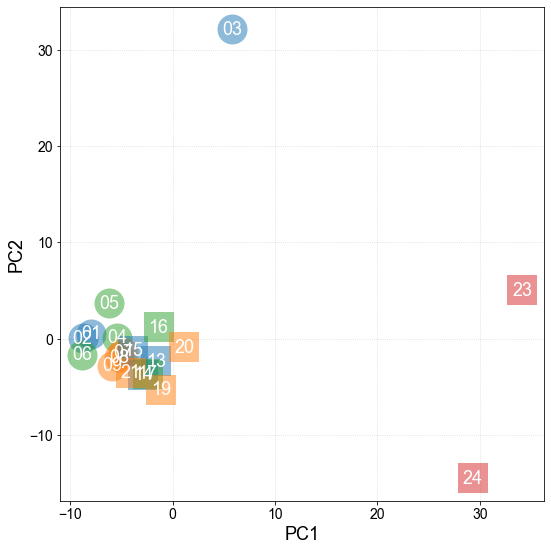

In [23]:
matplotlib.pyplot.figure(None, (8,8))
for i in range(PCs.shape[0]):
    matplotlib.pyplot.plot(PCs[i,0], PCs[i,1], marker=the_markers[i], color=the_colors[i], ms=30, alpha=0.5, mew=0)
    label = log2_HV_df.index[i][:2]
    matplotlib.pyplot.text(PCs[i,0], PCs[i,1], s=label, horizontalalignment='center', verticalalignment='center', color='w')
    
matplotlib.pyplot.xlabel('PC1')
matplotlib.pyplot.ylabel('PC2')
matplotlib.pyplot.grid(True,alpha=0.5,ls=':')
matplotlib.pyplot.tight_layout()

## 3.2. UMAP

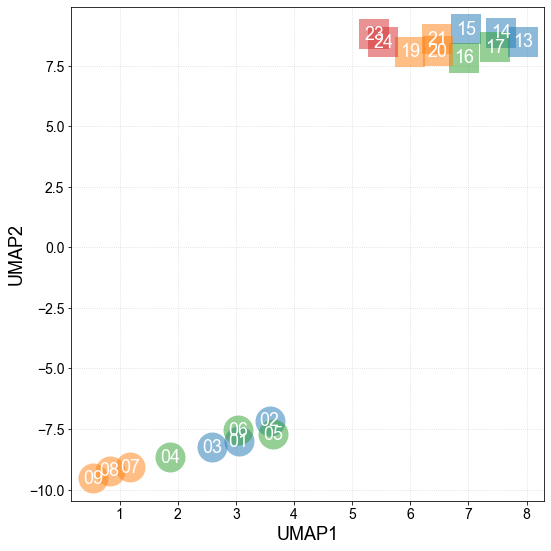

In [24]:
reducer = umap.UMAP(n_neighbors=3, metric='cosine')
embedding = reducer.fit_transform(log2_HV_df)


matplotlib.pyplot.figure(None, (8,8))
for i in range(embedding.shape[0]):
    matplotlib.pyplot.plot(embedding[i,0], embedding[i,1], marker=the_markers[i], color=the_colors[i], ms=30, alpha=0.5, mew=0)
    label = log2_HV_df.index[i][:2]
    matplotlib.pyplot.text(embedding[i,0], embedding[i,1], s=label, horizontalalignment='center', verticalalignment='center', color='w')
    
matplotlib.pyplot.xlabel('UMAP1')
matplotlib.pyplot.ylabel('UMAP2')
matplotlib.pyplot.grid(True,alpha=0.5,ls=':')
matplotlib.pyplot.tight_layout()

In [ ]:
# dimensionality reduction on VTs

(19, 2339)
(19, 2)


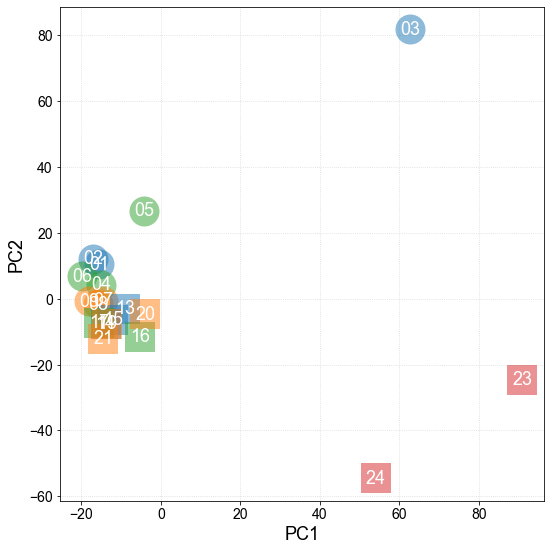

In [25]:
standarized = sklearn.preprocessing.StandardScaler().fit_transform(log2_V_df)
print(standarized.shape)
pca = sklearn.decomposition.PCA(n_components = 2)
PCs = pca.fit_transform(standarized)
print(PCs.shape)

the_colors = []
for element in log2_V_df.index:
        
    if '_0hr' in element:
        the_color = 'tab:blue'
    elif '_1hr' in element:
        the_color = 'tab:green'
    elif '_4hr' in element:
        the_color = 'tab:orange'
    elif '_24hr' in element:
        the_color = 'tab:red'
    else:
        print('error')
    the_colors.append(the_color)

the_markers = []
for element in log2_V_df.index:
    if 'hFOB' in element:
        the_marker = 's'
    else:
        the_marker = 'o'
    the_markers.append(the_marker)
    
matplotlib.pyplot.figure(None, (8,8))
for i in range(PCs.shape[0]):
    matplotlib.pyplot.plot(PCs[i,0], PCs[i,1], marker=the_markers[i], color=the_colors[i], ms=30, alpha=0.5, mew=0)
    label = log2_V_df.index[i][:2]
    matplotlib.pyplot.text(PCs[i,0], PCs[i,1], s=label, horizontalalignment='center', verticalalignment='center', color='w')
    
matplotlib.pyplot.xlabel('PC1')
matplotlib.pyplot.ylabel('PC2')
matplotlib.pyplot.grid(True,alpha=0.5,ls=':')
matplotlib.pyplot.tight_layout()

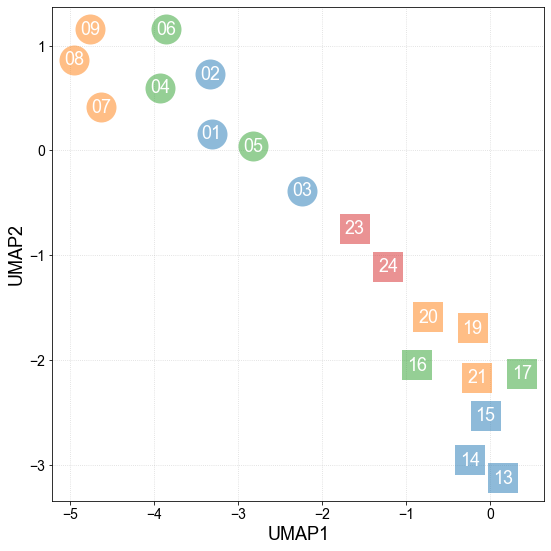

In [28]:
reducer = umap.UMAP(n_neighbors=3, metric='cosine')
embedding = reducer.fit_transform(log2_V_df)

matplotlib.pyplot.figure(None, (8,8))
for i in range(embedding.shape[0]):
    matplotlib.pyplot.plot(embedding[i,0], embedding[i,1], marker=the_markers[i], color=the_colors[i], ms=30, alpha=0.5, mew=0)
    label = log2_V_df.index[i][:2]
    matplotlib.pyplot.text(embedding[i,0], embedding[i,1], s=label, horizontalalignment='center', verticalalignment='center', color='w')
    
matplotlib.pyplot.xlabel('UMAP1')
matplotlib.pyplot.ylabel('UMAP2')
matplotlib.pyplot.grid(True,alpha=0.5,ls=':')
matplotlib.pyplot.tight_layout()